In [4]:
import sys
sys.path.append('..')

In [2]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')

In [3]:
tf.__version__

'2.0.0-rc1'

In [4]:
dataset_name = 'dsprites'

In [5]:
import tensorflow_datasets as tfds

info = tfds.builder(dataset_name).info

print(info)

tfds.core.DatasetInfo(
    name='dsprites',
    version=0.1.0,
    description='dSprites is a dataset of 2D shapes procedurally generated from 6 ground truth
independent latent factors. These factors are *color*, *shape*, *scale*,
*rotation*, *x* and *y* positions of a sprite.

All possible combinations of these latents are present exactly once,
generating N = 737280 total images.

### Latent factor values

*   Color: white
*   Shape: square, ellipse, heart
*   Scale: 6 values linearly spaced in [0.5, 1]
*   Orientation: 40 values in [0, 2 pi]
*   Position X: 32 values in [0, 1]
*   Position Y: 32 values in [0, 1]

We varied one latent at a time (starting from Position Y, then Position X, etc),
and sequentially stored the images in fixed order.
Hence the order along the first dimension is fixed and allows you to map back to
the value of the latents corresponding to that image.

We chose the latents values deliberately to have the smallest step changes
while ensuring that all pixel outp

In [6]:
intermediate_dim = 20
input_shape=(64, 64, 1) # image shape
batch_size = 100
latent_dim = 50

In [7]:
TRAIN_BUF = 600
TEST_BUF = 100


In [8]:
import tensorflow_datasets as tfds
# Construct a tf.data.Dataset
train_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TRAIN_BUF).batch(batch_size)
try:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TEST).shuffle(TEST_BUF).batch(batch_size)
except:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TEST_BUF).batch(batch_size)


In [9]:
_instance_scale=1.0
for data in train_ds:
    _instance_scale = float(data['image'][0].numpy().max())
    break

In [10]:
enc_lays2 = [
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(latent_dim)
]

dec_lays2 = [
    tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    
    # No activation
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME")
]

In [11]:
enc_mean_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

enc_var_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

dec_lays = [tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu')]

## First Time

In [12]:
#from utils.data_and_files.file_utils import make_random_string
#from time import gmtime, strftime

#model_name = 'AE_' + make_random_string(5) + strftime("%a_%d_%b_%Y_%H_%M", gmtime())
#print(model_name)

In [13]:
model_name = dataset_name+'AE'

In [14]:
recoding_dir='..\\recoding\\'+model_name

In [15]:
import os

In [16]:
os.path.join(recoding_dir, model_name)

'..\\recoding\\dspritesAE\\dspritesAE'

In [17]:
from training.autoencoders.AE import AE

Using TensorFlow backend.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [18]:
variables_params = \
[
    {
        'name': 'encoder', 
        'input_shape':input_shape,
        'output_shape':latent_dim,
        'layers': enc_mean_lays
    }
    ,
    
        {
        'name': 'decoder', 
        'input_shape':latent_dim,
        'output_shape':input_shape,
        'layers':dec_lays
    }
]

In [19]:
_restore = os.path.join(recoding_dir, 'var_save_dir')

In [20]:
_restore

'..\\recoding\\dspritesAE\\var_save_dir'

In [21]:
ae = AE( 
    model_name=model_name, 
    input_shape=input_shape, 
    latent_dim=latent_dim, 
    variables_params=variables_params, 
    restore=_restore
    )

INFO:tensorflow:Single-worker CollectiveAllReduceStrategy with local_devices = ('/device:GPU:0',), communication = CollectiveCommunication.NCCL


INFO:tensorflow:Single-worker CollectiveAllReduceStrategy with local_devices = ('/device:GPU:0',), communication = CollectiveCommunication.NCCL


  DEBUG    | MultiWorker Mirrored Strategy ... 
DEBUG:pythonConfig:MultiWorker Mirrored Strategy ... 


  DEBUG    | Restore old models ...
DEBUG:pythonConfig:Restore old models ...


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64, 64, 20)        40        
_________________________________________________________________
dense_3 (Dense)              (None, 64, 64, 20)        420       
_________________________________________________________________
dense_4 (Dense)              (None, 64, 64, 20)        420       
_________________________________________________________________
flatten_1 (Flatten)          (None, 81920)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                4096050   
Total params: 4,096,930
Trainable params: 4,096,930
Non-trainable params: 0
_________________________________________________________________



  WARNING  | None


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_9 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_10 (Dense)             (None, 40)                1640      
_________________________________________________________________
flatten_2 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 4096)              167936    
Total params: 173,256
Trainable params: 173,256
Non-trainable params: 0
_________________________________________________________________



  WARNING  | None


In [22]:
import numpy as np
n_generated = 36
#random_latent = np.random.normal(size=[n_generated, latent_dim])
#np.save(file='random_latent.npy', arr=random_latent)
random_latent = tf.constant(np.load(file='..\\data\\random_latent.npy'))

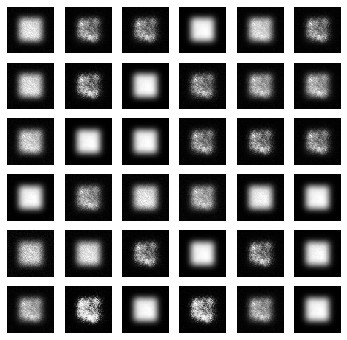

  INFO     | Found Record for 1 Epochs
INFO:pythonConfig:Found Record for 1 Epochs
Epochs Progress:   0%|                                                                          | 0/10 [00:00<?, ?it/s]

  INFO     | Training ... 
INFO:pythonConfig:Training ... 


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epochs Progress, Training Iterations 608:   0%|                                                 | 0/10 [00:42<?, ?it/s]

KeyboardInterrupt: 

In [23]:
ae.fit(
    train_dataset=train_ds, 
    test_dataset=test_ds,
    instance_name='image',
    instance_scale=_instance_scale,
    epochs=10,
    learning_rate=1e-3,
    random_latent=random_latent,
    latent_dim=latent_dim ,
    recoding_dir=recoding_dir,
    gray_plot=True,
    generate_epoch=5,
    save_epoch=5
)

In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from data.gt_load.datasets import load

In [62]:
DATA_PATH = '..\\data\\gt_datasets'

In [57]:
#DATA_PATH = 'C://Users//Khalid//Downloads//Generative Models//data//gt_datasets'

In [64]:
eval_dataset = load(dataset_name='dsprites_full', dataset_path=DATA_PATH)

In [65]:
import numpy as np

In [67]:
def rep_func(x):
    z, mean, logvar = vae.encode(x)
    return z

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from evaluation.unsupervised_metrics.compute_metrics import compute_unsupervised_metrics

In [70]:
us_scores = compute_unsupervised_metrics(
    ground_truth_data=eval_dataset, 
    representation_function=rep_func, 
    random_state=np.random.RandomState(0),
    num_train=737280,
    batch_size=batch_size
)
    

NameError: name 'batch_size' is not defined

In [71]:
us_scores

NameError: name 'us_scores' is not defined

In [ ]:
from evaluation.supervised_metrics.compute_metrics import compute_supervised_metrics

In [ ]:
s_scores = compute_supervised_metrics(
    ground_truth_data=eval_dataset, 
    representation_function=rep_func, 
    random_state=np.random.RandomState(0),
    num_train=10000,
    num_test=2000,
    continuous_factors=False,
    batch_size=batch_size
)
    

In [ ]:
s_scores